# Machine Learning Layer
#### Goal: Estimate the next beta

In [95]:
# Sources:
# - Scikit-Learn: Buitinck et al., (2013) - API design for machine learning software: experiences from the scikit-learn project, . (https://arxiv.org/abs/1309.0238)
# - XGBoost: Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785–794). New York, NY, USA: ACM. https://doi.org/10.1145/2939672.2939785

In [133]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tf as tf
from plotnine import *
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import RootMeanSquaredError

import pickle
import joblib

## 1) Import Data:
CSV file is created by running the matrix_data.py script. Alternatively an existing file has to be placed under ./Assets/Data/all_matrix_data_v3.csv

In [97]:
df = pd.read_csv('../../../../Assets/Data/all_matrix_data_v3.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

Display values:

In [98]:
df.sort_values('beta')

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
29931,8,69.342857,Other,-25.142857,11.585714,10.914286,4.397959,3.206650e-22,4.185804e-01,2020-05-05,Essen
33260,12,57.440000,Other,-1.857143,15.671429,7.557143,1.061224,7.422783e-22,4.248281e-01,2020-06-02,Rhein-Sieg-Kreis
33549,16,63.390000,Other,-10.142857,20.885714,NaN,0.897959,4.943590e-21,1.880543e-02,2020-06-30,Solingen
9519,21,58.802857,Other,7.285714,19.628571,4.685714,2.357143,1.138159e-20,6.482662e-01,2020-08-04,Potsdam-Mittelmark
11600,12,57.440000,Other,6.428571,13.542857,7.914286,0.408163,4.656590e-20,1.931945e-02,2020-06-02,Neuburg-Schrobenhausen
...,...,...,...,...,...,...,...,...,...,...,...
20441,18,58.804286,Other,9.285714,13.657143,13.928571,0.938776,3.929966e+00,5.671122e-07,2020-07-14,"Schwerin, Landeshauptstadt"
10613,70,73.210000,B.1.617.2,19.000000,18.071429,9.442857,0.734694,4.097204e+00,4.810871e-07,2021-07-13,Saale-Holzland-Kreis
22773,70,73.210000,B.1.617.2,17.000000,17.714286,7.914286,0.795918,4.198941e+00,4.614146e-07,2021-07-13,Regen
17021,18,58.804286,Other,-4.714286,13.414286,NaN,2.448980,4.277427e+00,5.615672e-07,2020-07-14,"Hof, Kreis"


## 2) Visualize Data:
#### 2.1) Average Infections (training period):

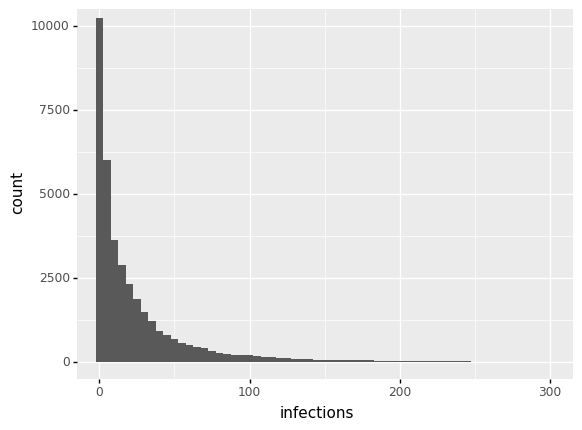

<ggplot: (394746299)>

In [99]:
ggplot(df, aes(x='infections')) + geom_histogram(binwidth=5) + coord_cartesian(xlim=(0,300),ylim=(0,10000))

#### 2.2) Fitted beta:

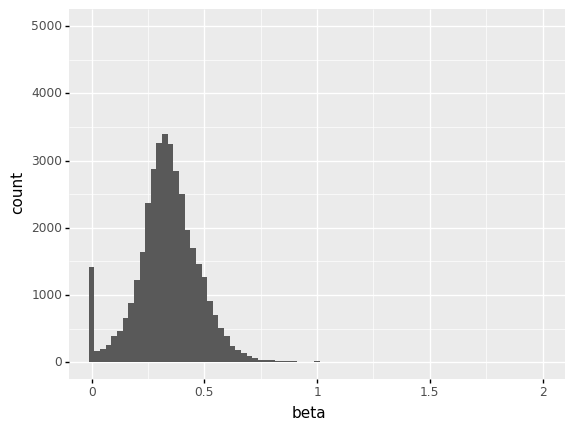

<ggplot: (391256474)>

In [100]:
ggplot(df, aes(x='beta')) + geom_histogram(binwidth=0.025) + coord_cartesian(xlim=(0,2),ylim=(0,5000))

Above it can be seen that the fitted betas roughly follow a normal distribution or probably rather a lognormal distribution. The values near 0 appear to be outliers. Such low values of the fitted beta can be observed either when the scipy least squares function is unable to find a minimum and returns some weird value which happens in very few cases or in cases where the infections counts for a specific district in a specific week is super low. We therefore decided to remove low beta values as they appear to be outliers that could distort results if one would keep them in.

In [101]:
# Sort values by district and week before lagging:
df.sort_values(['district','week'], inplace=True)

In [102]:
# Check out correlation between current and previous weeks beta:
df['beta'].corr(df['beta_t_minus_1'] )

-0.04946080063633077

## 3) Data cleaning:
#### Identify missing values:

In [103]:
df.isnull().sum()

week                         0
policy_index                 0
variant                      0
mobility                     0
temperature                243
wind                      3827
infections                   0
beta                         0
beta_t_minus_1               0
start_date_forecasting       0
district                     0
dtype: int64

#### Fill missing values with average value over all Germany for that specific week:

In [104]:
df_v4 = df.copy()

In [105]:
df_v4['temperature'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['temperature']
df_v4['wind'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['wind']

/var/folders/f9/_57rk_kx5jqbkd8vvnwckf2c0000gn/T/ipykernel_20821/1409488165.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
/var/folders/f9/_57rk_kx5jqbkd8vvnwckf2c0000gn/T/ipykernel_20821/1409488165.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.


In [106]:
df_v4

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
11400,2,46.258571,Other,-29.857143,8.400000,16.342857,56.214286,0.317049,0.593156,2020-03-24,Aachen
11401,3,62.500000,Other,-41.714286,5.171429,15.042316,51.448980,0.297109,0.319949,2020-03-31,Aachen
11402,4,63.778571,Other,-34.428571,5.914286,11.157143,34.714286,0.198582,0.345324,2020-04-07,Aachen
11403,5,65.180000,Other,-29.285714,15.071429,10.571429,23.693878,0.228998,0.210615,2020-04-14,Aachen
11404,6,65.180000,Other,-32.857143,11.085714,11.071429,15.510204,0.221865,0.217996,2020-04-21,Aachen
...,...,...,...,...,...,...,...,...,...,...,...
4080,92,83.930000,B.1.617.2,-2.571429,0.428571,8.528571,287.969388,0.318062,0.356566,2021-12-14,Zwickau
4081,93,83.930000,B.1.617.2,-1.000000,4.842857,10.485714,190.122449,0.283989,0.344724,2021-12-21,Zwickau
4082,94,83.930000,B.1.617.2,-4.285714,-1.200000,10.700000,138.816327,0.341186,0.277870,2021-12-28,Zwickau
4083,95,83.930000,B.1.1.529,-15.714286,7.871429,16.885714,103.153061,0.326760,0.343163,2022-01-04,Zwickau


## 4) Outlier removal:


In [107]:
# Identify outliers:

In [108]:
df_v4[df_v4['infections'] > 20].sort_values('beta_t_minus_1', ascending=True)

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,start_date_forecasting,district
14389,46,70.710000,Other,-0.142857,2.742857,18.042857,37.357143,0.321769,0.121853,2021-01-26,Mansfeld-Südharz
25501,43,73.690000,Other,-28.857143,2.228571,11.771429,88.224490,0.448059,0.133374,2021-01-05,Regionalverband Saarbrücken
32059,46,70.710000,Other,-25.714286,3.071429,16.442857,22.653061,0.177563,0.135390,2021-01-26,Potsdam
21511,43,73.690000,Other,-23.000000,-2.485714,5.785714,22.581633,0.430256,0.144703,2021-01-05,Oberallgäu
11224,16,63.390000,Other,-14.714286,21.171429,9.714286,24.653061,0.123700,0.147413,2020-06-30,Gütersloh
...,...,...,...,...,...,...,...,...,...,...,...
3414,91,81.761429,B.1.617.2,4.000000,2.657143,15.685714,297.683673,0.410829,0.885379,2021-12-07,Börde
20074,31,54.460000,Other,21.285714,10.400000,13.555102,20.265306,0.354283,0.984769,2020-10-13,Eifelkreis Bitburg-Prüm
29260,2,46.258571,Other,-21.000000,6.371429,9.557143,24.755102,0.611139,1.050508,2020-03-24,Neustadt a.d.Waldnaab
7439,31,54.460000,Other,12.142857,9.728571,10.114286,32.959184,0.550973,1.078371,2020-10-13,Berchtesgadener Land


#### 4.1) Infection counts:
Remove weeks in which the average number of daily infections where below a threshold as for extremely low values it is really hard to forecast beta:

In [109]:
# Drop all rows in which average number of infections is below 5:
threshold = 20
df_v5_1 = df_v4[df_v4['infections'] > threshold]

#### 4.2) Beta values:

In [110]:
# Drop all rows in which the beta value is < 0.025:
threshold = 0.025
df_v5_2 = df_v5_1[df_v5_1['beta'] > threshold]

In [111]:
# correlation:
df_v5_2['beta'].corr(df_v5_2['beta_t_minus_1'] )

0.46299469609533317

## 5) Preprocessing columns:


#### 5.1) Handling categorical columns:

In [112]:
# Only use week and district as index columns:
df_v6_1 = df_v5_2.set_index(['week','district','start_date_forecasting'])

In [113]:
# One hot-encode variant columns:
df_v6_2_a = pd.get_dummies(df_v6_1['variant'])
df_v6_2_b = df_v6_1.drop(columns='variant', axis=1)

df_v6_2_c = pd.concat([df_v6_2_a,df_v6_2_b], axis=1)

In [114]:
# Drop "other" variant column to prevent dummy variable trap:
df_v6_2_d = df_v6_2_c.drop(columns='Other', axis=1)

#### 5.2) Standardizing:

In [115]:
# Standardize:
scaler_obj = StandardScaler()

# Split explanatory columns from beta:
explanatory_cols = df_v6_2_d.drop(columns=['beta'], axis=1)
beta_cols = df_v6_2_d[['beta']]

# Apply scaling:
scaled_explanatory_cols = pd.DataFrame(scaler_obj.fit_transform(explanatory_cols), index=explanatory_cols.index, columns=explanatory_cols.columns)

# Merge both together again:
df_v6_3 = pd.concat([scaled_explanatory_cols, beta_cols], axis=1)

## 6) Modeling
### 6.1) Preparation
#### 6.1.1) Split into train/val:

In [116]:
df_full = df_v6_3
df_full

,,,B.1.1.529,B.1.1.7,B.1.617.2,policy_index,mobility,temperature,wind,infections,beta_t_minus_1,beta
week,district,start_date_forecasting,,,,,,,,,,
2,Aachen,2020-03-24,-0.243616,-0.635747,-0.782084,-2.522486,-1.813104,0.444563,1.244166,-0.141755,2.134192,0.317049
3,Aachen,2020-03-31,-0.243616,-0.635747,-0.782084,-0.675429,-2.643120,-0.210696,0.906138,-0.179311,-0.684498,0.297109
4,Aachen,2020-04-07,-0.243616,-0.635747,-0.782084,-0.530024,-2.133110,-0.059928,-0.103671,-0.311199,-0.422703,0.198582
5,Aachen,2020-04-14,-0.243616,-0.635747,-0.782084,-0.370647,-1.773103,1.798572,-0.255906,-0.398051,-1.812507,0.228998
29,Aachen,2020-09-29,-0.243616,-0.635747,-0.782084,-1.589778,0.366940,1.613012,0.806026,-0.358887,-0.438264,0.416920
...,...,...,...,...,...,...,...,...,...,...,...,...
92,Zwickau,2021-12-14,-0.243616,-0.635747,1.278635,1.761697,0.096934,-1.173288,-0.786872,1.684726,-0.306718,0.318062
93,Zwickau,2021-12-21,-0.243616,-0.635747,1.278635,1.761697,0.206936,-0.277381,-0.278184,0.913586,-0.428888,0.283989
94,Zwickau,2021-12-28,-0.243616,-0.635747,1.278635,1.761697,-0.023068,-1.503817,-0.222489,0.509238,-1.118625,0.341186


In [117]:
# Sample 1500 row out of last weeks available for training:
sample_size = 1000
max_week = max(df_full.index.get_level_values('week'))
last_weeks_idx = max_week-3

random_indices = df_full[df_full.index.get_level_values('week') >= last_weeks_idx].sample(sample_size).index

In [118]:
df_test = df_full.loc[df_full.index.isin(random_indices)]
df_modeling = df_full.loc[~df_full.index.isin(random_indices)]

#### 6.1.2) Split into train, val and test:

In [119]:
SEED = 420

In [120]:
X_full_modeling = df_modeling.drop(columns=['beta'], axis=1)
y_full_modeling = df_modeling['beta']

X_test = df_test.drop(columns=['beta'], axis=1)
y_test = df_test['beta']

In [121]:
# Train and Val:
X_train, X_val, y_train, y_val = train_test_split(X_full_modeling, y_full_modeling, shuffle=True, train_size=0.75, random_state=SEED)

### 6.2 Models
#### 6.2.1) Baseline Approach: Choosing previous beta

In [122]:
# Baseline approach would be to use the beta from the previous week for the next week:
## Therefore we have to compare how well this works, compared to our ML approach:

# As the values are standardized we have to reverse standardize them first:
y_pred_baseline_val = pd.DataFrame(scaler_obj.inverse_transform(X_val), index=X_val.index, columns=X_val.columns)['beta_t_minus_1']

In [123]:
# Correlation of this approach:
y_pred_baseline_val.corr(y_val)

0.4764627191900841

In [124]:
pd.DataFrame({'y_val':y_val, 'y_pred_baseline':y_pred_baseline_val})

,,,y_val,y_pred_baseline
week,district,start_date_forecasting,,
41,Heidekreis,2020-12-22,0.292271,0.355533
87,Unna,2021-11-09,0.584893,0.433737
56,Rhein-Lahn-Kreis,2021-04-06,0.352923,0.330851
77,Reutlingen,2021-08-31,0.370456,0.492598
34,Aachen,2020-11-03,0.307538,0.356226
...,...,...,...,...
87,Landkreis Rostock,2021-11-09,0.466446,0.541334
90,"Schwerin, Landeshauptstadt",2021-11-30,0.329809,0.477543
38,"Oldenburg, Kreis",2020-12-01,0.348867,0.344812


In [125]:
# Compute RMSE of baseline approach:
rmse_baseline =  mean_squared_error(y_val, y_pred_baseline_val, squared=False)
print(f'Baseline RMSE is: {rmse_baseline}')

Baseline RMSE is: 0.09672711770605946


#### 6.2.2) Multivariate Linear Regression

In [126]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred_linreg = regr.predict(X_val)
rmse_linreg = mean_squared_error(y_val, y_pred_linreg, squared=False)

In [127]:
print(f'RMSE of {regr} is: {rmse_linreg}. This is an improvement compared to the baseline approach of: {-(rmse_linreg / rmse_baseline -1)*100} %')

RMSE of LinearRegression() is: 0.06391656688113245. This is an improvement compared to the baseline approach of: 33.92073660732227 %


#### 6.2.3) Ridge Regression:

In [128]:
ridge_reg = linear_model.Ridge()
ridge_reg.fit(X_train, y_train)

y_pred_ridge_reg = ridge_reg.predict(X_val)
rmse_ridge_reg = mean_squared_error(y_val, y_pred_ridge_reg, squared=False)

In [129]:
print(f'RMSE of {ridge_reg} is: {rmse_ridge_reg}. This is an improvement compared to the baseline approach of: {-(rmse_ridge_reg / rmse_baseline -1)*100} %')

RMSE of Ridge() is: 0.06391682390945619. This is an improvement compared to the baseline approach of: 33.92047088212562 %


#### 6.2.4) Random Forest Regressor:

In [43]:
rfg_model = RandomForestRegressor()
rfg_model.fit(X_train, y_train)

y_pred_random_forest = rfg_model.predict(X_val)
rmse_random_forest = mean_squared_error(y_val, y_pred_random_forest, squared=False)

In [44]:
print(f'RMSE of {rfg_model} is: {rmse_random_forest}. This is an improvement compared to the baseline approach of: {-(rmse_random_forest / rmse_baseline -1)*100} %')

RMSE of RandomForestRegressor() is: 0.054877154306196156. This is an improvement compared to the baseline approach of: 43.62584736467906 %


#### 6.2.5) Support Vector Machines

In [45]:
svm = SVR()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_val)
rmse_svm = mean_squared_error(y_val, y_pred_svm, squared=False)

In [46]:
print(f'RMSE of {svm} is: {rmse_svm}. This is an improvement compared to the baseline approach of: {-(rmse_svm / rmse_baseline -1)*100} %')

RMSE of SVR() is: 0.06286229764031019. This is an improvement compared to the baseline approach of: 35.422876659956614 %


#### 6.2.6) XGBoost

In [47]:
xgb_model = xgb.XGBRegressor(verbosity=0)
xgb_model.name = 'XGBoostRegressor'
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_val)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)

In [48]:
print(f'\n RMSE of {xgb_model.name} is: {rmse_xgb}. This is an improvement compared to the baseline approach of: {-(rmse_xgb / rmse_baseline -1)*100} %')


 RMSE of XGBoostRegressor is: 0.05637486172096842. This is an improvement compared to the baseline approach of: 42.087283868249905 %


In [49]:
pd.DataFrame({'beta_opt':y_val, 'last_beta':y_pred_baseline_val, 'last_beta_standardized':X_val['beta_t_minus_1'], 'xgb_pred':y_pred_xgb}).sort_values('start_date_forecasting', ascending=False)

beta_opt  last_beta  \
week district                  start_date_forecasting                        
96   Neumarkt i.d.OPf.         2022-01-11              0.583710   0.478578   
     Roth                      2022-01-11              0.669952   0.455546   
     Stadt Landau in der Pfalz 2022-01-11              0.412759   0.521665   
     Neuburg-Schrobenhausen    2022-01-11              0.670107   0.583970   
     Salzgitter                2022-01-11              0.590606   0.607807   
...                                                         ...        ...   
2    Düsseldorf                2020-03-24              0.297559   0.562237   
     Zollernalbkreis           2020-03-24              0.437692   0.738657   
     Mettmann                  2020-03-24              0.301756   0.688205   
     Freising                  2020-03-24              0.372734   0.610251   
     Steinfurt                 2020-03-24              0.331492   0.657779   

                                                       last_beta_standardized  \
week district                  start_date_forecasting                           
96   Neumarkt i.d.OPf.         2022-01-11                            0.952087   
     Roth                      2022-01-11                            0.714465   
     Stadt Landau in der Pfalz 2022-01-11                            1.396616   
     Neuburg-Schrobenhausen    2022-01-11                            2.039421   
     Salzgitter                2022-01-11                            2.285349   
...                                                                       ...   
2    Düsseldorf                2020-03-24                            1.815206   
     Zollernalbkreis           2020-03-24                            3.635343   
     Mettmann                  2020-03-24                            3.114822   
     Freising                  2020-03-24                            2.310569   
     Steinfurt                 2020-03-24                            2.800920   

                                                       xgb_pred  
week district                  start_date_forecasting            
96   Neumarkt i.d.OPf.         2022-01-11              0.518309  
     Roth                      2022-01-11              0.530719  
     Stadt Landau in der Pfalz 2022-01-11              0.508652  
     Neuburg-Schrobenhausen    2022-01-11              0.518632  
     Salzgitter                2022-01-11              0.539648  
...                                                         ...  
2    Düsseldorf                2020-03-24              0.394669  
     Zollernalbkreis           2020-03-24              0.377255  
     Mettmann                  2020-03-24              0.351166  
     Freising                  2020-03-24              0.371359  
     Steinfurt                 2020-03-24              0.418631  

[3249 rows x 4 columns]

#### 6.2.7) Neural Network

In [50]:
ann_model = Sequential([
    Dense(24, input_dim=len(X_train.columns), activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])


# compile model:
ann_model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics=[RootMeanSquaredError(name='rmse')]
)

2022-02-22 16:44:26.976950: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [51]:
history = ann_model.fit(X_train,
                        y_train,
                        epochs=20,
                        # class_weight=class_weight,
                        validation_data=(X_val, y_val),
                        )

Epoch 1/20
305/305 [==============================] - 2s 4ms/step - loss: 0.0709 - rmse: 0.2663 - val_loss: 0.0089 - val_rmse: 0.0941
Epoch 2/20
305/305 [==============================] - 1s 3ms/step - loss: 0.0172 - rmse: 0.1313 - val_loss: 0.0071 - val_rmse: 0.0842
Epoch 3/20
305/305 [==============================] - 1s 3ms/step - loss: 0.0100 - rmse: 0.1000 - val_loss: 0.0057 - val_rmse: 0.0757
Epoch 4/20
305/305 [==============================] - 1s 3ms/step - loss: 0.0076 - rmse: 0.0873 - val_loss: 0.0052 - val_rmse: 0.0720
Epoch 5/20
305/305 [==============================] - 1s 3ms/step - loss: 0.0066 - rmse: 0.0812 - val_loss: 0.0055 - val_rmse: 0.0740
Epoch 6/20
305/305 [==============================] - 1s 3ms/step - loss: 0.0056 - rmse: 0.0747 - val_loss: 0.0052 - val_rmse: 0.0724
Epoch 7/20
305/305 [==============================] - 1s 3ms/step - loss: 0.0052 - rmse: 0.0722 - val_loss: 0.0047 - val_rmse: 0.0685
Epoch 8/20
305/305 [==============================] - 1s 3ms/s

In [52]:
y_pred_ann = ann_model.predict(X_val)
rmse_ann = mean_squared_error(y_val, y_pred_ann, squared=False)

In [53]:
print(f'RMSE of {ann_model} is: {rmse_ann}. This is an improvement compared to the baseline approach of: {-(rmse_ann / rmse_baseline -1)*100} %')

RMSE of <keras.engine.sequential.Sequential object at 0x1751c5490> is: 0.0639412177132556. This is an improvement compared to the baseline approach of: 34.31452463911088 %


## 7) Hyperparameter Tuning:
Here the goal is to tune the hyperparameters of the best performing models to increase the model performance even further:

In [65]:
# The parameters to be tuned:
# As an example the maximum depth of each tree in the ensemble can be set using the max_depth parameter.

params = {
    "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [77]:
# The above defined parameters are passed to the constructor of the randomized search cross validation object. Other params include the model to be tuned,
# the number of iterations (number of candidates that are tested) and the number of jobs to be executed at the same time for parallel processing (-1 indicates that all available kernels
# should be used. CV determines the number of splits to be used and verbose the level of additional information to be printed when executing the randomized
# grid search.
# As a scoring function / metric to evaluate the performance of different parameter settings we use the root mean squared error. The "neg" stands for
# negative. This is a technical detail as the negated score is needed all scorer objects follow the convention that higher return values are better
# than lower return values (https://scikit-learn.org/stable/modules/model_evaluation.html).

rs_model = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=25, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error', verbose=3)

In [78]:
# Execute fitting:
rs_model.fit(X_full_modeling, y_full_modeling)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          enable_categorical=False, gamma=0,
                                          gpu_id=-1, importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimato...
                                          reg_lambda=1, scale_pos_weight=1,
                                          subsample=1, tree_method='exac

In [85]:
# Print results (best estimators):
rs_model.best_params_

{'min_child_weight': 1,
 'max_depth': 6,
 'learning_rate': 0.15,
 'gamma': 0.0,
 'colsample_bytree': 0.5}

In [86]:
# Print results (best score):
f'Best RMSE-Score: {-rs_model.best_score_}'

'Best RMSE-Score: 0.054531922278637825'

In [90]:
# Train Model on full dataset:
xgb_model_tuned = rs_model.best_estimator_
xgb_model_tuned.fit(X_full_modeling, y_full_modeling)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

## 8) Model Evaluation:

### Metric Computation:

#### Baseline:

In [54]:
y_pred_baseline_test = pd.DataFrame(scaler_obj.inverse_transform(X_test), index=X_test.index, columns=X_test.columns)['beta_t_minus_1']
rmse_baseline_test = mean_squared_error(y_pred_baseline_test, y_test, squared=False)
print(f'RMSE of baseline approach is: {rmse_baseline_test}')

RMSE of baseline approach is: 0.13854113290109654


#### Random Forest:

In [55]:
# Apply optimal model to testset:
y_pred_test_rf = rfg_model.predict(X_test)

rmse_rf_test = mean_squared_error(y_pred_test_rf, y_test, squared=False)
print(f'RMSE of {rfg_model} is: {rmse_rf_test}. This is an improvement compared to the baseline approach of: {-(rmse_rf_test / rmse_baseline_test -1)*100}%')

RMSE of RandomForestRegressor() is: 0.0955794661852052. This is an improvement compared to the baseline approach of: 31.01004432132177%


#### XGB Boost:

In [92]:
# Apply optimal model to testset:
y_pred_test_xgb = xgb_model_tuned.predict(X_test)

xgb_model_tuned.name = 'XGBoost_tuned'

rmse_xgb_test = mean_squared_error(y_pred_test_xgb, y_test, squared=False)
print(f'RMSE of {xgb_model_tuned.name} is: {rmse_xgb_test}. This is an improvement compared to the baseline approach of: {-(rmse_xgb_test / rmse_baseline_test -1)*100}%')

RMSE of XGBoost_tuned is: 0.09660994411609913. This is an improvement compared to the baseline approach of: 30.266237836333964%


### Model comparison:

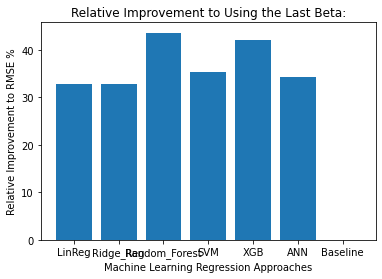

In [57]:
rmses_dict = {
    'LinReg': rmse_linreg,
    'Ridge_Reg': rmse_ridge_reg,
    'Random_Forest': rmse_random_forest,
    'SVM': rmse_svm,
    'XGB': rmse_xgb,
    'ANN':rmse_ann,
    'Baseline': rmse_baseline,
}

rmses_rel_improvement = {k:(-(v/rmse_baseline-1)*100) for (k,v) in rmses_dict.items()}
rmses_rel_improvement

plt.bar(x=rmses_rel_improvement.keys(),height=rmses_rel_improvement.values())
plt.title("Relative Improvement to Using the Last Beta:")
plt.xlabel(xlabel='Machine Learning Regression Approaches')
plt.ylabel(ylabel='Relative Improvement to RMSE %')
plt.show()

In [58]:
# Export results to csv:
import csv

with open('ml_results_dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in rmses_dict.items():
        writer.writerow([key, value])

In [59]:
os.getcwd()

'/Users/heidemann/Documents/Private/Project_Seminar/Backend/Modeling/Differential_Equation_Modeling/Machine_Learning_Layer'

### Residual analysis:

In [60]:
residuals_df = pd.DataFrame({
    'beta_opt':y_test, 'last_beta_pred':y_pred_baseline_test, 'xgb_pred':y_pred_test_xgb,
    'residual_last_beta': y_pred_baseline_test-y_test,
    'residual_xgb_pred': y_pred_test_xgb-y_test,
})
residuals_df

beta_opt  last_beta_pred  \
week district        start_date_forecasting                             
93   Aachen          2021-12-21              0.436077        0.354506   
94   Aachen          2021-12-28              0.592211        0.372149   
     Ahrweiler       2021-12-28              0.497854        0.296910   
95   Ahrweiler       2022-01-04              0.623046        0.344286   
96   Ahrweiler       2022-01-11              0.486081        0.679850   
...                                               ...             ...   
93   Zollernalbkreis 2021-12-21              0.313538        0.299271   
95   Zollernalbkreis 2022-01-04              0.474933        0.445366   
93   Zwickau         2021-12-21              0.283989        0.344724   
94   Zwickau         2021-12-28              0.341186        0.277870   
95   Zwickau         2022-01-04              0.326760        0.343163   

                                             xgb_pred  residual_last_beta  \
week district        start_date_forecasting                                 
93   Aachen          2021-12-21              0.353995           -0.081572   
94   Aachen          2021-12-28              0.351619           -0.220062   
     Ahrweiler       2021-12-28              0.375288           -0.200944   
95   Ahrweiler       2022-01-04              0.442217           -0.278760   
96   Ahrweiler       2022-01-11              0.575600            0.193769   
...                                               ...                 ...   
93   Zollernalbkreis 2021-12-21              0.396936           -0.014266   
95   Zollernalbkreis 2022-01-04              0.531422           -0.029567   
93   Zwickau         2021-12-21              0.340697            0.060735   
94   Zwickau         2021-12-28              0.337726           -0.063316   
95   Zwickau         2022-01-04              0.404947            0.016402   

                                             residual_xgb_pred  
week district        start_date_forecasting                     
93   Aachen          2021-12-21                      -0.082083  
94   Aachen          2021-12-28                      -0.240593  
     Ahrweiler       2021-12-28                      -0.122566  
95   Ahrweiler       2022-01-04                      -0.180829  
96   Ahrweiler       2022-01-11                       0.089519  
...                                                        ...  
93   Zollernalbkreis 2021-12-21                       0.083398  
95   Zollernalbkreis 2022-01-04                       0.056488  
93   Zwickau         2021-12-21                       0.056708  
94   Zwickau         2021-12-28                      -0.003461  
95   Zwickau         2022-01-04                       0.078186  

[1000 rows x 5 columns]

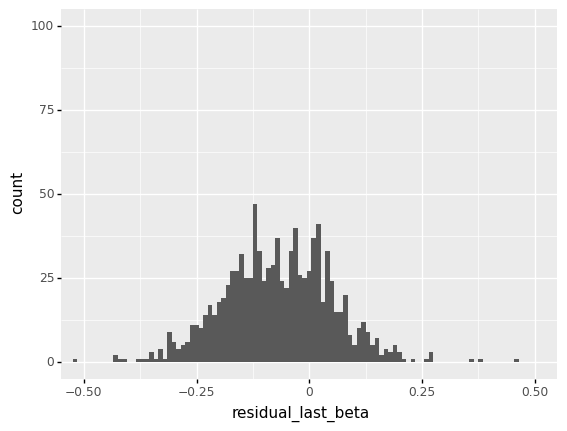

<ggplot: (391780220)>

In [61]:
## Plot residuals:
# Last Beta
ggplot(residuals_df, aes(x='residual_last_beta')) + geom_histogram(binwidth=0.01) + coord_cartesian(xlim=(-0.5,0.5),ylim=(0,100))

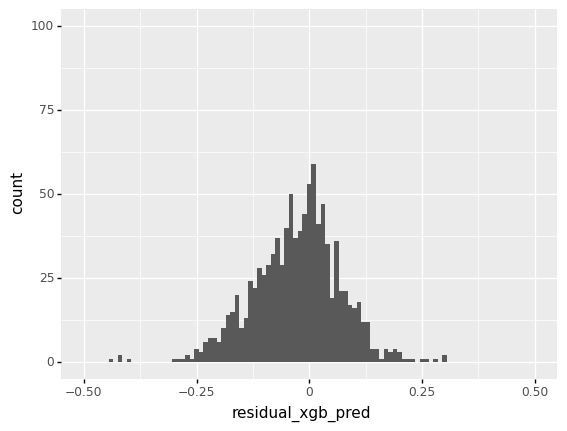

<ggplot: (391201711)>

In [62]:
# XGB Beta
ggplot(residuals_df, aes(x='residual_xgb_pred')) + geom_histogram(binwidth=0.01) + coord_cartesian(xlim=(-0.5,0.5),ylim=(0,100))

## 9) Export Best Model:

In [63]:
path = '../../../../Assets/MachineLearningLayer/Models/'
best_model = xgb_model

# ML Model:
filename = 'xgb_model_lukas.pkl'
combined_path = path+filename
joblib.dump(best_model, open(combined_path, 'wb'))

# Standardizer:
filename = 'standardizer_model.pkl'
combined_path = path+filename
joblib.dump(scaler_obj, open(path+filename, 'wb'))

print('succesfully exported')

succesfully exported
